<a href="https://colab.research.google.com/github/klajosw/python/blob/master/kl_py_okt_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"> 
    <img src="https://raw.githubusercontent.com/klajosw/python/master/kl_mie_python_logo_250.jpg" 
         align="left" width="251" height="251">
    
</p>


<p> </p>



# Python alapok 6

<https://klajosw.blogspot.com/>


---

# Adatok elemzése

Az alábbi példasorban két, gyakran előforduló adatelemzési problémát fogunk megvizsgálni. Az első a függvényillesztés, a második pedig a periodikus jelek (például hangminták) Fourier-analízise. Amint már azt megszokhattuk, először is töltsünk be néhány hasznos modult és függvényt!

In [0]:
%pylab inline
from scipy.optimize import curve_fit # Az illesztéshez használt függvény
from numpy.fft import *              # Fourier-analízishez használt rutinok

Populating the interactive namespace from numpy and matplotlib


## Függvényillesztés



Sokszor előfordul, hogy egy kísérlet eredményeit valamilyen elméleti becsléssel szeretnénk összevetni, illetve, hogy az elméletben szereplő paramétereket egy kísérlethez szeretnénk igazítani. Az egyik legelterjedtebb eljárás ennek a problémának a megoldására az úgynevezett legkisebb négyzetek módszere.

Tegyük fel, hogy a kísérleti adataink $(x_i,y_i)$ számpárokként állnak rendelkezésünkre, és van $N$ db mintapontunk, azaz $i=1\dots N$ ! Erre az adatsorra szeretnénk illeszteni egy $y=f(x,a,b,c,d,\dots)$ függvényt! A feladat az hogy olyan $a,b,c,d,\dots$ paramétereket találjunk, amik a legjobban közelítik az adatpontjainkat. Ezt a feladatot az $$S(a,b,c,d,\dots)=\sum_{i=1}^N (y_i-f(x_i,a,b,c,d,\dots))^2$$ függvény minimalizálásával oldhatjuk meg. Ez a legkisebb négyzetek módszerének lényege. Természetesen van Python-csomag, amely a legkisebb négyzetek módszerét használja, az alábbiakban ezzel fogunk megismerkedni néhány példán keresztül.

Generáljunk először egy adathalmazt, amit később vizsgálhatunk! Legyen ez egy zajos $\sin$ függvény!

In [0]:
t1 = linspace(0,10,100) # mintavételezés
zaj=0.3*randn(len(t1))  # normál eloszlású zaj
x1=1.5*sin(t1+2)+zaj     # egy zajos sin függvény
hiba=2*abs(zaj)        # ez a "mérés" hibája

Most nézzük is meg!

<Container object of 3 artists>

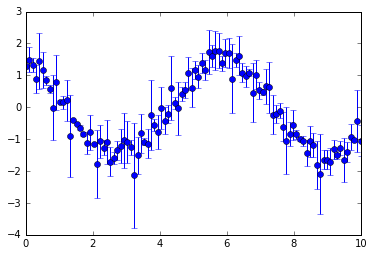

In [0]:
errorbar(t1,x1,hiba,marker='o',linestyle='')

A függvényillesztéshez a `curve_fit` függvényt fogjuk használni, ennek az első bemenete az a függvény, amelyet illeszteni szeretnénk. Definiáljuk tehát az illesztendő függvényt! Legyen ez $$f(t)=A\sin(\omega t+\varphi)$$ alakú!

In [0]:
def fun(t,A,omega,phi):
    return A*sin(omega*t+phi)

A `curve_fit` függvény az illesztendő függvény első változóját tekinti futó változónak, és a függvény többi paraméterét pedig meghatározandó paraméternek. Alapvetően két tömbbel tér vissza. Az első tömb tartalmazza a meghatározott illesztési paramétereket, a másik pedig az úgy nevezett kovarianciamátrixot. A kovarianciamátrix diagonális elemei határozzák meg az illesztett paraméterek pontosságát.

In [0]:
popt,pcov=curve_fit(fun,t1,x1) # az illesztés elvégzése
perr = sqrt(diag(pcov))      # az illesztési paraméterek hibáinak meghatározása
print (['A','omega','phi'])
print (popt)
print (perr)

['A', 'omega', 'phi']
[ 1.53582722  1.00691135  1.97696955]
[ 0.03986391  0.00910056  0.04989062]


A `popt` array első eleme az $A$ paraméter, a második az $\omega$, a harmadik pedig a $\varphi$.
Amint látszik, ez egy viszonylag jól sikerült illesztés, a paraméterek illesztési hibái az illesztett paraméterértékekhez képest kicsik! Mivel a mintaadatsort mi generáltuk 'kézzel', ezért ha összevetjük az illesztett értékeket az adatsor generálása során használt $A=1.5,\,\omega=1.0,\,\varphi=2.0$ értékkekkel, akkor ezen értékekhez is viszonylag közeli számokat kapunk! Az illesztett paraméterek ismeretében már ki tudjuk értékelni az illesztett függvényt. Tegyük ezt meg!

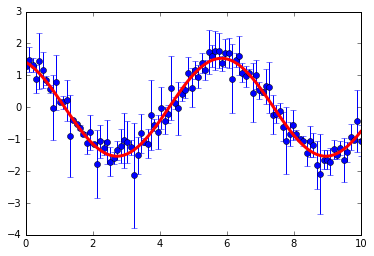

In [0]:
errorbar(t1,x1,hiba,marker='o',linestyle='') # az adatok ábrázolása
plot(t1,fun(t1,popt[0],popt[1],popt[2]),color='red',linewidth=3) # az illesztett függvény ábrázolása

A `curve_fit` parancs segítségével figyelembe tudjuk venni az eredeti adatoknak a mérési hibáit (amit a `hiba` válltozóban tároltunk el )! Ez azt jelenti, hogy az illesztés során azok a pontok, amelyek nagy mérési hibával rendelkeznek, kisebb súlyal vannak figyelembe véve, mint azok a pontok, ahol a mérési hiba kicsi. 
A mérési hibák figyelembe vétele a `sigma` kulcsszóval történik meg. Nézzük meg, mi történik, ha megadjuk a hibákat!

In [0]:
popt_hibaval,pcov_hibaval=curve_fit(fun,t1,x1,sigma=hiba)
perr_hibaval = sqrt(diag(pcov_hibaval))
print (['A','omega','phi'])
print (popt_hibaval)
print (perr_hibaval)

['A', 'omega', 'phi']
[ 1.48184745  0.99871729  2.0061375 ]
[ 0.01214574  0.00169755  0.00561813]


Ha összehasonlítjuk a hibák figyelembevételével történt illesztést és a hiba nélküli illesztést, azt tapasztaljuk, hogy az illesztett paraméterek kicsit megválltoztak, **de** illesztési hiba jóval kisebb! Hasonlítsuk össze a két illesztési módszerrel kapott paraméterezést! Az alábbi példában az előzőhöz képest egy kicsit kompaktabb írásmódot alkamazunk a paramétervektor [kicsomagolásával](http://django.arek.uni-obuda.hu/python3-doc/html/tutorial/controlflow.html#argumentumlista-kicsomagolasa).

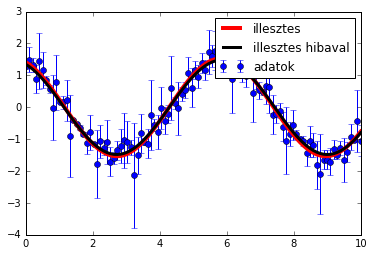

In [0]:
errorbar(t1,x1,hiba,marker='o',label='adatok',linestyle='') 
plot(t1,fun(t1,*popt),color='red',label='illesztes',linewidth=4)  # itt használtuk az argumentumok kicsomagolását                  
plot(t1,fun(t1,*popt_hibaval),color='black',label='illesztes hibaval',linewidth=3)  # itt is.
legend()

Az illesztési allgoritmusok, amik a `curve_fit` parancs mélyén elvégzik az illesztési feladatokat, nem mindig találják meg a megfelelő paramétereket. Ha egy illeszési feladatban sok meghatározandó paraméter van, akkor ez a probléma sokkal súlyosabb lehet. Vizsgáljunk meg erre egy másik adatsort. A  `data/ket_gauss_plus_hiba` file egy zajos adatsort tartalmaz, ami két Gauss-görbe összege. Próbáljunk meg erre illeszteni egy olyan függvényt, ami két Gauss-görbe összege! Először olvassuk be a file-t és jelenítsük meg!

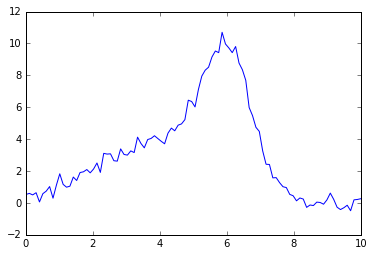

In [0]:
t2,x2=loadtxt('data/ket_gauss_plus_hiba',unpack=True) # beolvasas
plot(t2,x2)                        # megjelenites

Az alábbiakban definiáljuk az illesztendő függvényt!
$$f_2(t)=A_1\mathrm{e}^{-(t-e_1)^2/s_1^2}+A_2\mathrm{e}^{-(t-e_2)^2/s_2^2}$$

In [0]:
def func2(t,A1,e1,s1,A2,e2,s2):
    'Ket Gauss-gorbe osszege'
    return A1*exp(-((t-e1)/s1)**2)+A2*exp(-((t-e2)/s2)**2)

Próbáljuk ezzel elvégezni az illesztést!

In [0]:
popt,pcov=curve_fit(func2,t2,x2)
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

Úgy tűnik, az illesztés nem sikerült! Ez az adatsor és a meghatározandó függvény tehát jól illusztrálja a fent említett problémát!

Az illesztés nagyobb valószínűséggel sikeres lehet, ha a megillesztendő paramétereket az illesztés előtt valamilyen módon meg tudjuk becsülni. A fenti adatsorban például van egy nagy csúcs 6 körül, aminek a szélessége nagyjából 1, és magassága 10, továbbá egy viszonylag széles váll a csúcstól balra, ami egy szélesebb és laposabb csúcsból származhat, mondjuk 4 körül egy 4 magasségú és 3 szélességű csúcsból. Ábrázoljuk az eredeti függvényt, és ezt a két becsült függvényt!

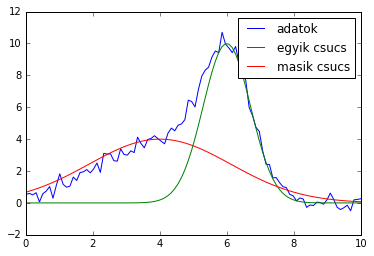

In [0]:
plot(t2,x2,label='adatok') # az adatok
plot(t2,10*exp(-((t2-6)/1)**2),label='egyik csucs') # a magasabb és vékonyabb csúcs
plot(t2,4*exp(-((t2-4)/3)**2),label='masik csucs')  # a szélesebb de alacsonyabb csúcs
legend()

A `curve_fit` függvénynek megadhatjuk ezeket a becsült értékeket mint az illesztési procedúra kezdő értékeit. Ezt a `p0` kulcsszón kerresztül tehetjük meg.

In [0]:
A1=10;e1=6;s1=1
A2=4;e2=4;s2=3
popt,pcov=curve_fit(func2,t2,x2,p0=[A1,e1,s1,A2,e2,s2]) # A p0-ba egyszeruen felsoroljuk a becsult ertekeket
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

['A1', 'e1', 's1', 'A2', 'e2', 's2']
[ 8.21260636  5.99414772  1.0291653   3.83303602  3.88151827  2.48802627]
[ 0.32159323  0.0130322   0.03320234  0.11389945  0.13779395  0.12601698]


A becslés tehát segített az illesztés elvégzésében! Ábrázoljuk végül az illesztett függvényt, az eredeti adatokat, illetve az eredetileg  becsült görbéket!

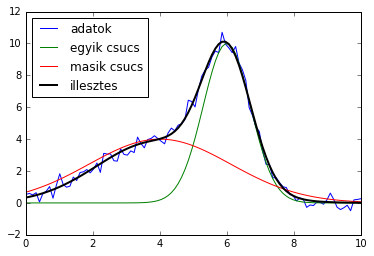

In [0]:
plot(t2,x2,label='adatok') # a beolvasott adatok
plot(t2,10*exp(-((t2-6)/1)**2),label='egyik csucs') # a két becsült Gauss
plot(t2,4*exp(-((t2-4)/3)**2),label='masik csucs')
plot(t2,func2(t2,*popt),label='illesztes',color='black',linewidth=2) # az illesztéssel meghatározott gorbe
legend(loc='upper left')

A korábbi feladatok között már szerepelt Felix Baumgartner ugrásának adatsora. Most újra vizsgáljunk meg ehhez kapcsolódóan egy életszerű illesztési problémát! 

Az ugrás első fázisában ($t=0\dots 40$ s) a mozgás jó közelítéssel szabadeséssel írható le: mielőtt az ejtőernyő kinyílna, a légellenállás kiegyensúlyozza a gravitációs erőt, és az esés sebessége közelítőleg állandó (kb $t=210\dots 260$ s  intervallumban).

Határozzuk meg a nehézségi gyorsulás értékét a pálya elején szereplő pontokból, illetve határozzuk meg
Felix Baumgartner légellenállását a pálya végén szereplő pontokból!
Kezdjük a feladatot a felhasznált fizikai jelenségek [összefoglalásával](http://www.livescience.com/23710-physics-supersonic-skydive.html)!

**Szabadesés az ugrás elején**

Mivel a szabadesés egyenletesen gyorsuló mozgásnak felel meg, ezért a magasság--idő függvényt a $$h(t)=h_0+v_0t-\frac{g}{2}t^2,$$ alakban kereshetjük! A nehézségi gyorsulás tehát meghatározható a pálya elejére illesztett parabola együtthatóiból hiszen a négyzetes tag együtthatójának a kétszerese épen $g$!

**Egyenletes sebesség az ugrás végén**

Mivel nincs gyorsulás, ezért ezen a ponton a közegellenállás és a gravitációs erő kiegyenlítik egymást!
Azaz $$mg=\alpha v^2 $$, amiből a közegellenállás  $\alpha=\frac{mg}{v^2}$. 
Baumgartner [súlya](http://www.livescience.com/23710-physics-supersonic-skydive.html) a szkafanderrel együtt kb 110 kg. Az illesztésből pedig meg tudjuk határozni $v$-t.

In [0]:
tB,h=loadtxt('data/h_vs_t',unpack=True) # adatok beolvasása
# ido az elso oszlop
# magassag a masodik

Definiáljuk most az illesztendő függvényeket. Egy lineáris függvényt és egy másodfokú polinomot!

In [0]:
def linearis(x,a,b):
    'Linearis fuggveny: a*x+b'
    return a*x+b

def masodfok(x,a,b,c):
    'Masodfoku fuggveny: a*x^2+b*x+c '
    return a*x**2+b*x+c

Először illeszünk egy másodfokú polinomot az adatsor elejére. Az adatsor megfelelő részét az array-ek már ismert szeletelésével tudjuk megoldani. 

In [0]:
p_eleje,pcov =curve_fit(masodfok,tB[tB<40],h[tB<40]) # illesztes azon pontokra ahol az ido kissebb mint 40
err_eleje = sqrt(diag(pcov))
# az illesztett parameterek ertekei es a hibak
print('a=',p_eleje[0],'±',err_eleje[0]) 
print('b=',p_eleje[1],'±',err_eleje[1])
print('c=',p_eleje[2],'±',err_eleje[2])

a= -4.74047528359 ± 0.0285659683743
b= 45.2385570965 ± 1.16034897662
c= 38893.934827 ± 9.87019931891


A gravitációs gyorsulás tehát az illesztett $a$ paraméter kétszerese!

In [0]:
g=abs(p_eleje[0]*2)
g

9.4809505671794199

Végezzük el az illesztést most a lineáris szakaszra is! Most is célszerű a már megismert indexelési trükkökkel megszorítani az illesztendő ttartományt. 

In [0]:
p_vege,pcov =curve_fit(linearis,tB[(tB>210)*(tB<260)],h[(tB>210)*(tB<260)]) # illesztes azon pontokra ahol az ido 210 es 260 kozott van
err_vege = sqrt(diag(pcov))
# az illesztett parameterek ertekei es a hibak
print('a=',p_vege[0],'±',err_vege[0]) 
print('b=',p_vege[1],'±',err_vege[1])

a= -60.1648024714 ± 0.145934354195
b= 18299.0046872 ± 34.3553394487


A keresett sebességérték tehát ismét az első illesztett paraméter értékéből határozható meg. Míg $\alpha $ az $\alpha=mg/v^2$ kifejezésből adódik:

In [0]:
v=p_vege[0]
m=110
alpha= m*g/v**2
alpha

0.28811082561386603

Foglaljuk össze eredményeinket egy ábrában!

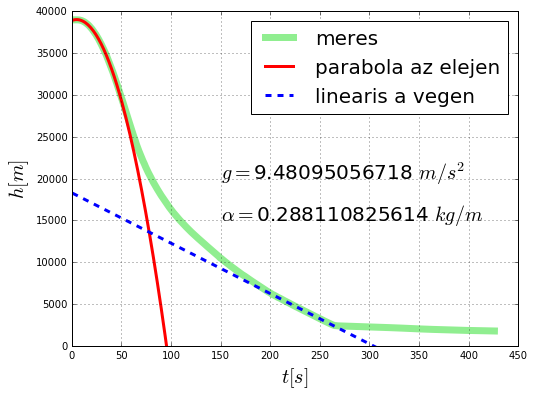

In [0]:
figsize(8,4*3/2)
plot(tB,h,label='meres',linewidth=7,color='lightgreen')
plot(tB,masodfok(tB,*p_eleje),label='parabola az elejen',linewidth=3,color='red')
plot(tB,linearis(tB,*p_vege),label='linearis a vegen',linestyle='dashed',linewidth=3,color='blue')
ylim(0,40000)
legend(fontsize=20)
xlabel(r'$t[s]$',fontsize=20)
ylabel(r'$h[m]$',fontsize=20)
text(150,20000,r'$g=$'+str(g)+r' $m/s^2$',fontsize=20)
text(150,15000,r'$\alpha=$'+str(alpha)+r' $kg/m$',fontsize=20)
grid()

In [0]:
figsize(6,4) #Ez csak vissza állítja az ábraméreteket az alapértelmezettre 

## Periodikus jelek vizsgálata és a Fourier-transzformáció
![winamp](http://winampheritage.com/plugin/222660/EZ_Spectrum_Analyzer.png)

Számtalan fizikai rendszerben előfordul az, hogy bizonyos jelenségek periodikus viselkedést mutatnak. A hétköznapból talán a legismertebb példa erre a zene. Sok zenelejátszó (amint azt a fenti ábra is bizonyítja) rendelkezik "spektrumanalizátorral". Ezek a spektrumanalizátorok azt mutatják, hogy egy bizonyos hang minta milyen frekveniájú hangokat tartalmaz. A módszer, ami egy adott hangmintából a frekvenciaspektrumot előállítja, a [Fourier-transzformáció](https://hu.wikipedia.org/wiki/Fourier-transzform%C3%A1ci%C3%B3).
Egy függvény Fourier-transzformáltját az alábbi matematikai kifejezés definiálja:
$$ \mathcal{F}[f](\nu)=\int^{\infty}_{-\infty} \mathrm{e}^{\mathrm{i 2\pi\nu t}}f(t)$$
A Fourier-transzformáció elvégzésére létezik egy gyors [allgoritmus](http://itl7.elte.hu/jelfel/node32.htm), ami igen sok alkalmazásban felbukkan. A Python-nyelvben a `numpy.fft` almodulban van implementálva a gyors Fourier transzformáció, az alábbi néhány példában ezzel fogunk megismerkedni. Ezt az almodult már a notebook elején betöltöttük!

Először generáljunk egy meghatározott $\nu$ frekvenciájú, azaz $\omega=2\pi\nu$ körfrekvenciájú jelet! Ezt például a 

$$f(t)=\sin(\omega t)$$ függvény. (Vajon melyik függvény ennek a Fourier-transzformáltja?)

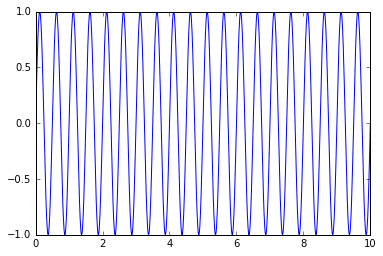

In [0]:
t3 = linspace(0,10,1000) # mintavetelezesi pontok
nu=2;                   # frekvencia
omega=2*pi*nu           # korfrekvencia
jel=sin(omega*t3)        # maga a jel
plot(t3,jel)

Maga a Fourier-transzformáció egyszerűen az `fft` függvény meghívásával történik.

In [0]:
Fjel=fft(jel)

Most már az `Fjel` változó tartalmazza a jel Fourier-transzformáltját! Ahogy azt a definició is mutatja, a Fourier- transzformált általában egy komplex kifejezés. A legtöbb alkalmazás szempontjából elegendő a Fourier-transzformált abszolút értékének vizsgálata.
Ahhoz hogy a Fourier-transzformált jelet ábrázolni tudjuk a frekvencia függvényében, először le kell gyártanunk egy megfelelő frekvencia-mintavételezést. Ennek a mintavételezésnek illenie kell az eredeti idő-mintavételezéshez. A frekvencia-mintavételezést az `fftfreq` függvény végzi el. Ennek két bemenő paramétere van. Az első paraméter az eredeti idősor hossza, a második paraméter pedig az idősor felbontása (lépésköze). 

In [0]:
freq = fftfreq(len(t3),t3[1]-t3[0])

Most már meg tudjuk jeleníteni a Fourier-transzformált abszolút értékét!

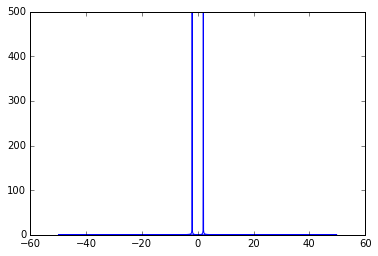

In [0]:
plot(freq,abs(Fjel))

A Fourier-transzformált pozitív és negatív frekvenciaértékekre is definiálva van, azonban időfüggő jelek elemzése során elegendő pozitív frekvenciákra szorítkoznunk. 

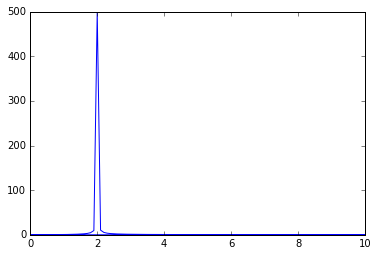

In [0]:
plot(freq,abs(Fjel))
xlim(0,10);

Tehát egy 2 frekvenciával oszcilláló jel Fourier-transzformáltja egy éles csúcs pontosan 2-nél (talán nem túl meglepő módon)!

Vizsgáljuk meg utolsó példaképpen a napfoltadatok számának ingadozását! Vajon látszani fog benne a 11 éves periódusidő ?
A napfoltadatok ismét az `data/SN_m_tot_V2.0.txt` file-ban vannak. Olvassuk őket be!

In [0]:
napfolt=loadtxt('data/SN_m_tot_V2.0.txt');

A harmadik oszlop tartalmazza az időt években, a negyedik oszlop pedig a napfoltok számát tartalmazza. 

In [0]:
tN=napfolt[:,2]
N=napfolt[:,3]

Gyártsuk le a frekvencia-mintavételezést, és végezzük el a Fourier-transzformáltat!

In [0]:
freqN = fftfreq(len(tN),tN[1]-tN[0])
FN=fft(N)

Végül ábrázoljuk a kapott Fourier-spektrumot!

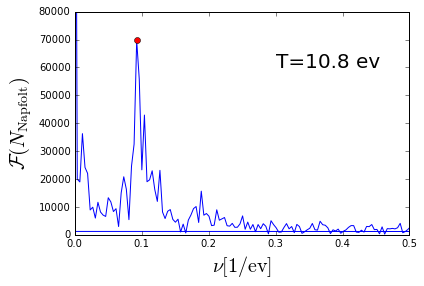

In [0]:
plot(freqN,abs(FN)) # A spektrum ábrázolása
xlim(0,0.5)
ylim(0,80000)
# A maximum hely megtalálása
maxN=max(abs(FN)[(freqN>0.03)*(freqN<0.2)])
maxf=freqN[(abs(FN)==maxN)*(freqN>0)]
plot(maxf,maxN,'o',color='red') # Egy kis piros pont a csúcson
xlabel(r'$\nu [1/\mathrm{ev}]$',fontsize=20)
ylabel(r'$\mathcal{F}(N_{\mathrm{Napfolt}})$',fontsize=20)
text(0.3,60000,'T='+str(1/maxf[0])+' ev',fontsize=20)

Tehát a Fourier-transzformált egy éles maximumot mutat 10.8 évnél! Azaz a megfigyelések Fourier-transzformáltja alapján is nagyjábol 11 éves periódussal változik a naptevékenységek intenzitása!